<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
ticker = "MU"
look_back = 5 # 5 days
max_data_size = 730 # 2 years
split_percent = 0.90 # use 90 of the data  for train
zoom = 180 # last 180 days see in chart

In [16]:
stock_api_response = pd.read_json('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T')
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);
#print(list(stock_api_data.items()))
data = []
for key, value in stock_api_data.items():
  data.append([
      pd.to_datetime(key,).date(),
      value.get('1. open'),
      value.get('2. high'),
      value.get('3. low'),
      value.get('5. adjusted close')
      ])

last_data =  str(data[0][0])
print(data[0])
if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
print('data size:',len(data), 'max_data_size:', max_data_size)

[datetime.date(2021, 10, 19), '67.37', '67.889', '66.64', '67.57']
data size: 730 max_data_size: 730


In [17]:
df = pd.DataFrame(data,columns=['Date','Open','High','Low','Close'])

#df['50MA'] = df['Close'].rolling(50).mean()
#df['100MA'] = df['Close'].rolling(100).mean()
#df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
df.head()

,Date,Open,High,Low,Close
0,2018-11-26,37.75,37.79,35.53,36.5185509285
1,2018-11-27,36.09,37.45,36.02,36.9479459764
2,2018-11-28,37.29,39.0,35.99,38.6555402364
3,2018-11-29,38.3,38.71,37.73,37.8566657288
4,2018-11-30,37.75,38.63,36.94,38.5057512662


['Open', 'High', 'Low', 'Close']
    Open   High    Low      Close
0  37.75  37.79  35.53  36.518551
1  36.09  37.45  36.02  36.947946
2  37.29  39.00  35.99  38.655540
3  38.30  38.71  37.73  37.856666
4  37.75  38.63  36.94  38.505751
(730, 4)


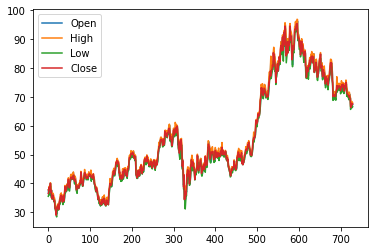

In [18]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
print(df_for_training.head())

df_for_plot=df_for_training
df_for_plot.plot.line()
print(df_for_training.shape)